<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>



# Introduction to the SpeciesEvolver component

<hr>
<small> For instructions on how to run an interactive Jupyter notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

In this tutorial we build and run a model that exemplifies SpeciesEvolver functionality. You will have the opportunity to
* Populate a model grid with taxa.
* Evolve taxa in response to climate change.
* View the SpeciesEvolver record that stores model variables over time.
* Plot some model output.

This tutorial demonstrates the default, simplest capabilities of SpeciesEvolver. With this Landlab component you can explore evolutionary links between landscape and life, including among species and other taxonomic levels. The component tracks and evolves `Taxon` objects. See the documentation for information upon other capabilities, including subclassing the ``Taxon`` class.

## Example model: climate change impacts on taxa distribution and evolution

### Premise

Ecosystems zonate by elevation in large part because surface air temperature decreases with altitude. Long term temperature change alters the landscape connectivity within elevations zones, and connectivity affects gene flow, leading to the question: ***How is vegetation macroevolution impacted by temperature changes?***

### Approach

We model the macroevolutionary processes of taxa in response to temperature change. The type of taxa is described as vegetation species in the text of this notebook. Although, nothing in the code designates the taxa as vegetation or as a species taxonomic level.

The model progresses in terms of time steps with an unprescribed duration. Initial conditions are set in time 0. The initial topography is loaded from a previously run model and does not change for the duration of the model in this notebook. Note that SpeciesEvolver can be used with a prescribed irregular or regular time step duration, e.g. a number of years.

In this model, air surface temperature at each time step is set by elevation using a lapse rate, the decrease of temperature with elevation. The temperature at base level in time 0 is 26&deg;C. The temperature throughout the grid is calculated using the base level temperature and the lapse rate. The temperature is decreased by 5&deg;C in both times 1 and 2.

At each time step, species distribution is set only by temperature, for simplicity of demonstration. The change in connectivity of species populations drive macroevolutionary processes built into the programmed species.

SpeciesEvolver is built to be adapted for many model approaches, especially for different taxa properties and behaviors. We will use `ZoneTaxon` in this notebook. This taxon type is distributed with SpeciesEvolver and relies on `Zone` objects to evaluate evolutionary processes. The macroevolutionary processes built into `ZoneTaxon` are
* dispersal: geographic range expansion
* speciation: lineage splitting (a taxon produces child taxa)
* extinction: lineage termination (a taxon no longer exists)

Speciation is modeled only as allopatric speciation that occurs as populations of a taxon become geographically isolated. Speciation triggered not by geographic isolation (sympatric speciation) is not modeled here, although it can be implemented by extending the speciation method of `ZoneTaxon` (see the documentation of this class).

In this model, the geographic range of species exists with the temperatures, 18&deg;C and 24&deg;C inclusive, meaning the extent of zones is within this interval at each time step, and all species exist only within these temperatures at each time step.

### Summary

In this model, we

* Set surface air temperture across a model grid as a function of elevation.
* Populate species within the grid. These species exist within a fixed temperature interval.
* Simulate three time steps where surface air temperature has changed in the latter two steps, and species respond to this change.
* Examine how the number of species, "taxa richness" changes as the model progresses.

## Import modules

The zones of ZoneTaxon are managed by a `ZoneController`, so we must import this class along with the SpeciesEvolver component and the other modules used in this notebook.

In [1]:
from landlab.components import SpeciesEvolver, Profiler
from landlab.components.species_evolution import ZoneController
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np

## Prepare the grid

### Load topography

Here the topography of the model grid is loaded from a file. The topography was previously developed using a model built with Landlab. An initial surface was uplifted, stream erosion was conducted using the FastscapeEroder component, and hillslope diffusion was conducted using the LinearDiffuser component. The model was run until topography reached steady state.

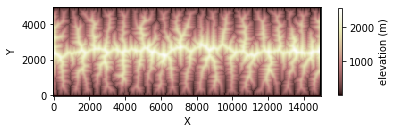

In [2]:
# Create a model grid and set a topographic elevation field.
(mg, z) = read_esri_ascii('model_grid_steady_state_elevation.txt')
mg.at_node['topographic__elevation'] = z

# Set the top and bottom grid boundaries to open.
mg.set_closed_boundaries_at_grid_edges(right_is_closed=True,
                                       top_is_closed=False,
                                       left_is_closed=True,
                                       bottom_is_closed=False)

# Plot the elevation field.
imshow_grid(mg, 'topographic__elevation', colorbar_label='elevation (m)', shrink=0.4)

### Create a grid field of air temperature at the land surface

We set a surface air temperature at base level (upper and lower boundaries). We use a lapse rate to create a  surface air temperature field at all nodes of the grid. The lapse rate, *L* is modeled as the decrease of temperature, *T* with increasing elevation, *z* as

\begin{align*}
L = -\frac{\delta t}{\delta z}
\end{align*}

We use a constant lapse rate of -5&deg;C / km.

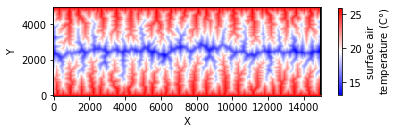

In [3]:
# Set a rate of temperature decrease per meter of elevation increase.
lapse_rate = -0.005

# Create a surface air temperature field.
temperature_at_base_level = 26
T = lapse_rate * z + temperature_at_base_level
mg.add_field('node', 'land_surface_air__temperature', T)

# Plot temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='bwr')

## Setup SpeciesEvolver and zones

The general workflow of working with zones and zone-based taxa using SpeciesEvolver is

* Initialize the SpeciesEvolver component.
* Setup zones and zone-based taxa:
    * Define a function that identifies the grid nodes where all zones will be created.
    * Initialize a ZoneController that will create and manage zones.
    * Populate zones with taxa.
* Introduce species to SpeciesEvolver so the component will track them over time.

### Initialize SpeciesEvolver

This component requires only one parameter, a model grid.

In [4]:
se = SpeciesEvolver(mg)

View `record_data_frame` of our SpeciesEvolver instance. Time and other model variables are stored in the attribute that is a Pandas DataFrame. The first and second columns are the row number and model time, respectively. We also see that 0 taxa exist. We have yet to introduce taxa.

In [5]:
se.record_data_frame

,time,taxa
0,0,0


### About zones

Zones help to evaluate the spatial aspect of `ZoneSpecies` macroevolutionary processes. We must create a function to map all areas that meet the qualifications of zones. (In this notebook's model, we will create a function to map the grid areas within a temperature interval.) Attributes of a zone include `mask` that indicates where in the grid the zone exists and `taxa`, which are the `ZoneTaxon` associated and extant within the zone.

At each time step, the spatial connectivity of the zones between the current and prior time steps are identified. For example, consider two consecutive time steps where a zone in the prior time intersects two zones in the later time. This type of connection in the zones of SpeciesEvolver is referred to as 'one-to-many' represented here

![](images/zone_path__one_to_many.png)

where the red arrows represent zone connectivity over time, and

<img style="float: left;" src="images/zone__one_to_none.png"> &nbsp; zone<sub>*t*</sub>: a zone in time, *t*. ('the earlier time')<br>

<img style="float: left;" src="images/zone__later_time.png"> &nbsp; zone<sub>*t*+1</sub>: a zone in the time following *t*. ('the later time')

Behind the scenes, macroevolution rules are programmed into `ZoneTaxon` that are evaluated considering zone connection type. The outcome of the rules given the connection type are described in the table below.

<center>connection type</center> | <center>graphical<br>represention</center> | <center>connectivity description</center> | <center>macroevolution implications</center>
--- | --- | --- | ---
one-to-none | ![](images/zone__one_to_none.png) | zone<sub>*t*</sub> does not intersect a zone in *t*+1. | The taxa in the zone of the earlier time will go extinct. 
one-to-one | ![](images/zone__one_to_one.png) | zone<sub>*t*</sub> intersects zone<sub>*t*+1</sub>. | The taxa in the zone of the earlier time moves along with the zone of the later time.
one-to-many | ![](images/zone__one_to_many.png) | zone<sub>*t*</sub> intersects multiple zones in *t*+1. | The taxa in the zone of the earlier time disperses across the multiple zones in the later time. The taxa in the zones of the later time are geographical disconnected, thus speciation occurs.
many-to-one | ![](images/zone__many_to_one.png) | Multiple zones in *t* intersect zone<sub>*t*+1</sub>. | The taxa in the earlier zones are relocated to the zone in the later time. Taxa density increases if zone<sub>*t*+1</sub> is smaller than the the earlier time zones combined.
many-to-many | ![](images/zone__many_to_many.png) | Multiple zones in *t* intersect multiple zones in *t*+1. | The taxa in each zone of *t* relocates to all zones in *t*. All taxa extant at the earlier time step speciates as their range becomes fragmented in the later time step.

### Create a zone function

The zone function identifies all grid nodes where zones are to be created. A zone is created for each cluster of spatially continuous nodes.

The zone function has the following two requirements:
1. It must return a boolean numpy array equal to the grid's `number_of_nodes`.
2. The first parameter must be named `grid`. It is the same Landlab grid supplied to SpeciesEvolver. Additional parameters are allowed.

For the model in this tutorial, we define a zone function that indicates zones should be created where the air temperature is between 18&deg;C and 24&deg;C, inclusive.

In [6]:
def zone_func(grid):
    """Get a mask of the total zone extent."""
    T = grid.at_node['land_surface_air__temperature']
    T_max = 25
    T_min = 18
    zone_extent_mask = np.all([T >= T_min, T <= T_max], 0)
    return zone_extent_mask

To demonstrate the output of this function, `True` values are shaded white in the plot below. Zones will be created in the masked area (in white).

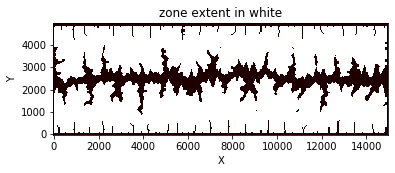

In [7]:
imshow_grid(mg, zone_func(mg), allow_colorbar=False, plot_name='zone extent in white')

### Initialize ZoneController

Next, we instantiate a ZoneController that will create and manage the zones. We used an optional parameter, `minimum_area` to indicate the minimum area of the zones to be created. Zones will be created upon initialization of this controller.

In [8]:
zc = ZoneController(mg, zone_func, minimum_area=50000)

Above, the mask returned by the `zone_func` indicates where zones should be created.

Below, we see ZoneController created two zones, one for each spatially distinct node cluster in the `zone_func` mask.

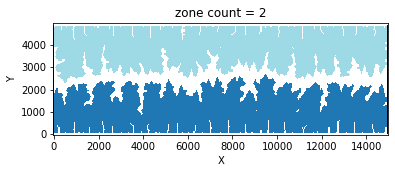

In [9]:
# Create a map of all zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(zc.zones):
    zone_map[zone.mask] = i + 1

# Plot zone map.
cmap = plt.cm.tab20
cmap.set_under('w')
title = 'zone count = {}'.format(len(zc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=1)

Multiple instances of ZoneController may be used with the same instance of SpeciesEvolver. This is useful when you wish to model groups of taxa where each group needs a different `zone_func`, for instance, fish and bears.

### Plot initial profile

Species dispersal at each time step will be considered by plotting the zone temperature interval alongside a topographic profile.

This initial profile is plotted across the main west-east divide.

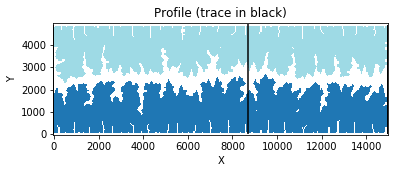

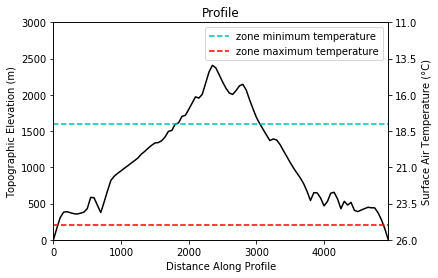

In [10]:
# Plot profile in map view.

endpoints = [29874, 174]
profiler = Profiler(mg, endpoints)
profiler.run_one_step()
profiler.plot_profiles_in_map_view(
    color='k', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name='Profile (trace in black)', vmin=1
)

# Plot profile.

fig, ax0 = plt.subplots()
profiler.plot_profiles(
    ylabel='Topographic Elevation (m)',
    color='k',
    title='Profile')
ax0.set_ylim([0, 3000])

ax1 = ax0.twinx()
ax1.set_ylim(ax0.get_ylim())
ax1.set_yticklabels(lapse_rate * ax0.get_yticks() + temperature_at_base_level)
ax1.set_ylabel('Surface Air Temperature (\N{DEGREE SIGN}C)')

# Include species temperature bounds.

upper = (18 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 5000], [upper, upper], 'c--', label='zone minimum temperature')

lower = (25 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 5000], [lower, lower], 'r--', label='zone maximum temperature')

_ = ax0.legend()

The profile (north is on the left) also illustrates that the two zones are seperated by the area around the main divide. This area is below the minimum zone temperature, therefore the ZoneController excluded zone creation here.

### Seed zones with taxa

A taxa is populated to each of the two initial zones using the ZoneController method, `populate_zones_uniformly`. This method creates species and populates it to each zone. (Any number of taxa can be populated to zones, and zones can be populated with different numbers of species.)

In [11]:
taxa = zc.populate_zones_uniformly(1)

### Introduce taxa to SpeciesEvolver

All species must be introduced using the SpeciesEvolver method, `track_taxa` in order for the species to be tracked by SpeciesEvolver.

In [12]:
se.track_taxa(taxa)

Two species now exist in SpeciesEvolver.

In [13]:
se.record_data_frame

,time,taxa
0,0,2


The SpeciesEvolver attribute, `taxa_data_frame` provides data about all of the tracked taxa, both extant and extinct. The data is presented in a Pandas DataFrame. Each row is data about a taxon.

In [14]:
se.taxa_data_frame

,appeared,latest_time,extant
uid,,,
0,0,0,True
1,0,0,True


``uid`` is the unique identifiers used to reference and retrieve a ``Taxon`` object, demostrated later in this notebook. Taxa are assigned identifiers in the order they are introduced to SpeciesEvolver. 

`appeared` is the model time when the taxon was introduced to SpeciesEvolver.

`latest_time` is the most recent model time the taxon was extant.

`extant` indicates if the taxon persists in the latest (current) model time.

## Model time step 1

Initial conditions were established in time 0. Next, climate change is modeled by increasing the temperature at base level by 5&deg;C.

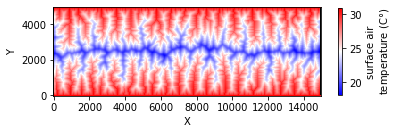

In [15]:
# Update the temperature field.
temperature_at_base_level += 5
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

# Plot the temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='bwr')

Here we advance ZoneController and SpeciesEvolver in time by one time step. ZoneController is advanced first in order to update the zones prior to calling SpeciesEvolver.

`dt` is set to 1 only because the duration of a time step is not prescribed in this tutorial. This `1` does not signify that one time step is run. We use 1 to make it simple to think about the time step sequence. Often, you may wish to make `dt` be the number of years in a time step.

In [16]:
dt = 1
zc.run_one_step(dt)
se.run_one_step(dt)

One zone now exists because the temperature increase raised the area that falls within the temperature range prescribed in `zone_func`.

Plot the zones.

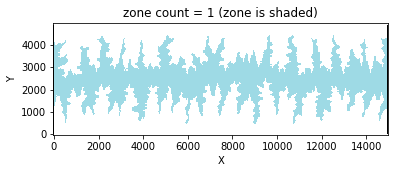

In [17]:
# Create a map of all zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(zc.zones):
    zone_map[zone.mask] = i + 1

# Plot zone map.
title = 'zone count = {} (zone is shaded)'.format(len(zc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=0.5)

A 'many-to-one' zone connectivity occurred in this time step relative to the previous time step, meaning neither speciation or extinction were triggered by zone change. (See zone connectivity table above.)

The same two taxa of time 0 exist in time 1. Their geographic range is all that changed.

In [18]:
se.taxa_data_frame

,appeared,latest_time,extant
uid,,,
0,0,1,True
1,0,1,True


### Plot a profile across the main divide

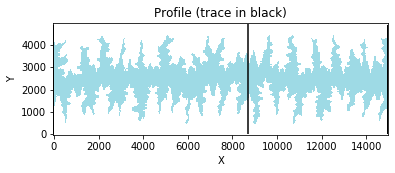

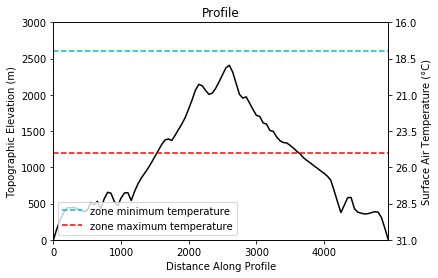

In [19]:
# Plot profile in map view.

endpoints = [174, 29874]
profiler = Profiler(mg, endpoints)
profiler.run_one_step()
profiler.plot_profiles_in_map_view(
    color='k', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name='Profile (trace in black)', vmin=0.5
)

# Plot profile.

fig, ax0 = plt.subplots()
profiler.plot_profiles(
    ylabel='Topographic Elevation (m)',
    color='k',
    title='Profile')
ax0.set_ylim([0, 3000])

ax1 = ax0.twinx()
ax1.set_ylim(ax0.get_ylim())
ax1.set_yticklabels(lapse_rate * ax0.get_yticks() + temperature_at_base_level)
ax1.set_ylabel('Surface Air Temperature (\N{DEGREE SIGN}C)')

# Include species temperature bounds.

upper = (18 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 5000], [upper, upper], 'c--', label='zone minimum temperature')

lower = (25 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 5000], [lower, lower], 'r--', label='zone maximum temperature')

_ = ax0.legend()

Species were able to cross the main divide following the temperature increase. The two species now exist in the same area. Coexisting has no effect because ZoneTaxon do not interact in the default implemention of the code for this species.

## Model time step 2

Temperature is again increased by 5&deg;C in time step 2.

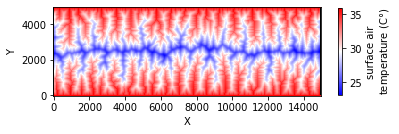

In [20]:
# Update the surface temperature field.
temperature_at_base_level += 5
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

# Plot temperature field.
imshow_grid(
    mg, 'land_surface_air__temperature',
    colorbar_label='surface air\ntemperature (C$\degree$)',
    shrink=0.4, cmap='bwr'
)

Advance ZoneController and SpeciesEvolver, and plot zones.

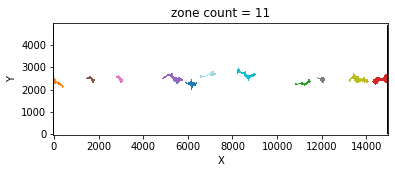

In [21]:
zc.run_one_step(dt)
se.run_one_step(dt)

# Create a map of all zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(zc.zones):
    zone_map[zone.mask] = i + 1

# Plot zone map.
title = 'zone count = {}'.format(len(zc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=0.5)

The grid now contains more zones than the prior time step. The macroevolutionary effect of this `one-to-many` zone connectivity relationship is examined in the next section.

## Examine model outcome

In the taxa DataFrame, we see 24 taxa existed during the model. Taxa 0 and 1 are known to exist as late as time 2. All other taxa appeared at time 2, the final time step. Something happened between time steps 1 and 2 when taxa 0 and 1 went extinct and 22 other taxa were created.

In [22]:
se.taxa_data_frame

,appeared,latest_time,extant
uid,,,
0,0,2,False
1,0,2,False
2,2,2,True
3,2,2,True
4,2,2,True
5,2,2,True
6,2,2,True
7,2,2,True
8,2,2,True


In the SpeciesEvolver record DataFrame, we see 22 speciations at time 2. We also see two pseudoextinctions were recognized at this time. A pseudoextinction occcurs when a taxon that is no longer extant because it speciated into child taxa.

In [23]:
se.record_data_frame

,time,taxa,speciations,extinctions,pseudoextinctions
0,0,2,NaN,NaN,NaN
1,1,2,0.0,0.0,0.0
2,2,22,22.0,2.0,2.0


A summary of the taxa in this model:

- 0 and 1: The initial taxa we introduced.
- 2...12: The child taxa of taxon 0.
- 13...23: The child taxa of taxon 1.

Next we will examine the model history using the plot below

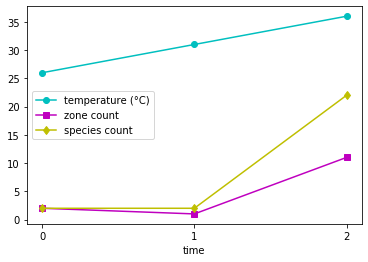

In [24]:
# Create a plot of key model variables over time.

time = se.record_data_frame.time
temperature = [26, 31, 36]
n_zones = zc.record_data_frame.zones
n_species = se.record_data_frame.taxa

plt.plot(time, temperature, 'o-c', label='temperature (\N{DEGREE SIGN}C)')
plt.plot(time, n_zones, 's-m', label='zone count')
plt.plot(time, se.record_data_frame.taxa, 'd-y', label='species count')
plt.xlabel('time')
plt.xticks(time)
_ = plt.legend()

### Plot time 1 profile along the main divide

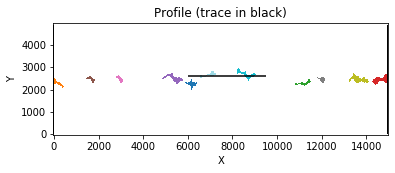

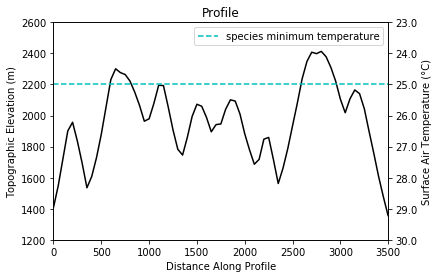

In [25]:
# Plot profile in map view.

endpoints = [15720, 15790]
profiler2 = Profiler(mg, endpoints)
profiler2.run_one_step()
profiler2.plot_profiles_in_map_view(
    color='k', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name='Profile (trace in black)', vmin=1
)

# Plot profile.

fig, ax0 = plt.subplots()
profiler2.plot_profiles(
    ylabel='Topographic Elevation (m)',
    color='k',
    title='Profile')
ax0.axis(ymin=1200, ymax=2600)

ax1 = ax0.twinx()
ax1.set_ylim(ax0.get_ylim())
ax1.set_yticklabels(lapse_rate * ax0.get_yticks() + temperature_at_base_level)
ax1.set_ylabel('Surface Air Temperature (\N{DEGREE SIGN}C)')

# Include species min elevation line.

z_min = (25 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 3500], [z_min, z_min], 'c--', label='species minimum temperature')
_ = ax0.legend()

The profile trace crosses two zones (upper figure). The topography is above the elevation with the minimum species temperature for these three zones (lower figure).

An additional increase in temperature drove species to become isolated on mountain peaks along the main divide. Species could not reach adjacent peaks because valleys were too cold. Each peak that was above the minimum species temperature led to an isolated population that produced a child species. In the model we ran, nine peaks/divide areas met these qualifications, thus species 0 and 1 produced 11 child species each.

## Model complete: examine the species

SpeciesEvolver automatically creates a `species__richness` grid field. We can use this field to see that there are two species in each zone. (species richness = number of species) Each zone contains a descendent species from each of the two initial species.

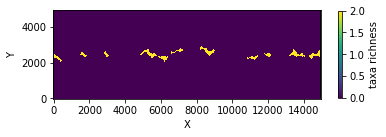

In [26]:
imshow_grid(
    mg, 'taxa__richness', colorbar_label='taxa richness',
    shrink=0.4, cmap='viridis'
)

Similar to SpeciesEvolver, ZoneController has a `record_data_frame` that stores model variables over time. The ZoneController stores variables pertinent to zones.

In the ZoneController record, 'fragmentation_count' in time 2 is nine. The one zone in time 1 split into nine fragments, or zones, essentially between times 1 and 2.

We see capture statistics in this record as well. Here, a capture indicates that a zone captured area from a zone in a prior time step. The one zone in time 1 captured the two zones in time 0.

In [27]:
zc.record_data_frame

,time,zones,fragmentations,captures,area_captured_sum,area_captured_max
0,0,2,NaN,NaN,NaN,NaN
1,1,1,0.0,1.0,29340000.0,29340000.0
2,2,11,11.0,0.0,0.0,0.0


Pandas DataFrame methods can be used on `record_data_frame`. For example, here we get the maximum capture count.

In [28]:
zc.record_data_frame.zones.max()

11

### Retrieve taxon objects

Metadata of taxa can be viewed in `taxa_data_frame`, although taxon objects cannot be retrieved from this DataFrame. Taxon objects are retrieved using the SpeciesEvolver method, `get_taxon_objects`. With these objects you can work with individual taxon, including plotting its geographic range as demonstrated below.

All of the introduced taxa and their child taxa are returned when no parameters are inputted into `get_taxon_objects`. This method returns all of the taxa that have existed in the SpeciesEvolver instance of this notebook.

In [29]:
se.get_taxon_objects()

[<ZoneTaxon, uid=0>,
 <ZoneTaxon, uid=1>,
 <ZoneTaxon, uid=2>,
 <ZoneTaxon, uid=3>,
 <ZoneTaxon, uid=4>,
 <ZoneTaxon, uid=5>,
 <ZoneTaxon, uid=6>,
 <ZoneTaxon, uid=7>,
 <ZoneTaxon, uid=8>,
 <ZoneTaxon, uid=9>,
 <ZoneTaxon, uid=10>,
 <ZoneTaxon, uid=11>,
 <ZoneTaxon, uid=12>,
 <ZoneTaxon, uid=13>,
 <ZoneTaxon, uid=14>,
 <ZoneTaxon, uid=15>,
 <ZoneTaxon, uid=16>,
 <ZoneTaxon, uid=17>,
 <ZoneTaxon, uid=18>,
 <ZoneTaxon, uid=19>,
 <ZoneTaxon, uid=20>,
 <ZoneTaxon, uid=21>,
 <ZoneTaxon, uid=22>,
 <ZoneTaxon, uid=23>]

The taxa can be filtered by the time they existed. To do so, we can use the optional parameter, `time` to indicate we want the taxa extant at time 0, the first two taxa introduced.

In [30]:
se.get_taxon_objects(time=0)

[<ZoneTaxon, uid=0>, <ZoneTaxon, uid=1>]

Get a taxon with a specific identifier using the  `uid` parameter. This method always returns a list so we get only the object at the first index.

In [31]:
taxon_12 = se.get_taxon_objects(uid=12)[0]
taxon_12

<ZoneTaxon, uid=12>

With a taxon object retrieved, we can work with it as we need. Here we plot its geographic range. The `range_mask` attribute of a taxon is a mask of its geographic range.

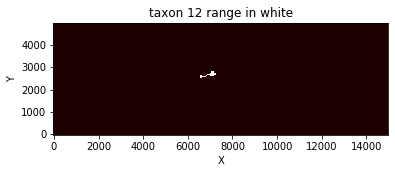

In [32]:
mask = taxon_12.range_mask
imshow_grid(mg, mask, plot_name='taxon 12 range in white', allow_colorbar=False)

The taxa with a common ancestor can be retrieved with the `ancestor` parameter. Here we get the taxa that descended from taxon 0 and then print only the identifiers of these descendents.

In [33]:
filtered_taxa = se.get_taxon_objects(ancestor=0)
[s.uid for s in filtered_taxa]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Taxon 0 is one of the initial taxa, and became pseudoextinct as it speciated to taxa 2...12 when the zone fragmented prior to time 2. The same sequence of events occurred for taxon 1 and its descendents, 13...23. This phylogeny is explained by the one zone capture that brought together the two initial taxa, followed by the 11 zones fragmentations that drove the 22 speciations of the child taxa and 2 pseudoextinctions of the initial taxa.

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>